### Libraries

In [ ]:
#!pip install wordcloud

In [78]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Importing Dataframes

In [19]:
working_directory = r"/Users/jafar/Downloads/cis 490/Instacart data/unzipped csvs/" 
os.chdir(working_directory)

In [24]:
sourcefiles = os.listdir(working_directory)
print(sourcefiles, end = " ")

['products.csv', 'orders.csv', 'order_products__train.csv', 'departments.csv', 'aisles.csv', 'order_products__prior.csv', 'sample_submission.csv'] 

In [23]:
del(sourcefiles[5])

In [25]:
# Below we are using list comprehension (a backwards for loop) to only take the first part (i.e. only grab 'aisles' from 'aisles.csv') of the .csv file name
file_names = [os.path.splitext(file)[0] for file in sourcefiles if file.endswith(".csv")]
print(file_names)

# For this next part, we will be using dictionary comprehension which is exactly like list comprehension, but for dictionaries
# The keys for our dictionary will be the file names and the values will the different dataframes 
dfs = {key: pd.read_csv(os.path.join(working_directory, file)) for key, file in zip(file_names, sourcefiles) if file.endswith(".csv")}

['products', 'orders', 'order_products__train', 'departments', 'aisles', 'order_products__prior', 'sample_submission']


In [26]:
# Now that we have our dictionary of dataframes, we can save each dataframe into their own variables
products_df = dfs["products"]
orders_df = dfs["orders"]
departments_df = dfs["departments"]
aisles_df = dfs["aisles"]
order_products_prior_df = dfs["order_products__prior"]

In [27]:
print(dfs.keys())

dict_keys(['products', 'orders', 'order_products__train', 'departments', 'aisles', 'order_products__prior', 'sample_submission'])


In [29]:
# Shape of each dataframe
for key,value in dfs.items():
    print(f"{key}: {value.shape}")

products: (49688, 4)
orders: (3421083, 7)
order_products__train: (1384617, 4)
departments: (21, 2)
aisles: (134, 2)
order_products__prior: (32434489, 4)
sample_submission: (75000, 2)


### Merging dataframes

In [30]:
aisle_product_merged = pd.merge(aisles_df, products_df, on = "aisle_id", how = "inner")
aisle_product_merged.head()

,aisle_id,aisle,product_id,product_name,department_id
0,1,prepared soups salads,209,Italian Pasta Salad,20
1,1,prepared soups salads,554,Turkey Chili,20
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20
4,1,prepared soups salads,2539,Original Potato Salad,20


In [31]:
#  Merge dataframes to show products, aisles, and departments they are found in
department_aisle_merged = pd.merge(aisle_product_merged, departments_df, on = "department_id", how = "inner")
department_aisle_merged.shape

(49688, 6)

In [32]:
#Merge the orders, products, and order_products_prior dataframes on “order_id” and “product_id”
orders_merged = pd.merge(orders_df, order_products_prior_df, on = "order_id", how = "left")
orders_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0


In [33]:
#  Merge the orders, products, and order_products_prior dataframes on “order_id” and “product_id” 
orders_product_merged = pd.merge(orders_merged, products_df, on = "product_id", how = "inner")
orders_product_merged.shape

(32434489, 13)

### EDA

Print the summary stats for the merged dataframes 

In [34]:
#summary statistics
department_aisle_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
aisle_id,49688.0,67.769582,38.316162,1.0,35.00,69.0,100.00,134.0
product_id,49688.0,24844.500000,14343.834425,1.0,12422.75,24844.5,37266.25,49688.0
department_id,49688.0,11.728687,5.850410,1.0,7.00,13.0,17.00,21.0


In [35]:
orders_product_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,32434489.0,1.710749e+06,987300.696453,2.0,855943.0,1711048.0,2565514.0,3421083.0
user_id,32434489.0,1.029372e+05,59466.478268,1.0,51421.0,102611.0,154391.0,206209.0
order_number,32434489.0,1.714205e+01,17.535040,1.0,5.0,11.0,24.0,99.0
order_dow,32434489.0,2.738818e+00,2.090049,0.0,1.0,3.0,5.0,6.0
order_hour_of_day,32434489.0,1.342498e+01,4.246365,0.0,10.0,13.0,16.0,23.0
days_since_prior_order,30356421.0,1.110407e+01,8.778914,0.0,5.0,8.0,15.0,30.0
product_id,32434489.0,2.557634e+04,14096.689090,1.0,13530.0,25256.0,37935.0,49688.0
add_to_cart_order,32434489.0,8.351076e+00,7.126671,1.0,3.0,6.0,11.0,145.0
reordered,32434489.0,5.896975e-01,0.491889,0.0,0.0,1.0,1.0,1.0
aisle_id,32434489.0,7.121430e+01,38.203023,1.0,31.0,83.0,107.0,134.0


In [36]:
department_aisle_merged.isnull().sum()

aisle_id         0
aisle            0
product_id       0
product_name     0
department_id    0
department       0
dtype: int64

In [37]:
orders_product_merged.isnull().sum()

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
dtype: int64

In [38]:
department_aisle_merged.head()

,aisle_id,aisle,product_id,product_name,department_id,department
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli
1,1,prepared soups salads,554,Turkey Chili,20,deli
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20,deli
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20,deli
4,1,prepared soups salads,2539,Original Potato Salad,20,deli


In [78]:
orders_product_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77,7
1,2398795,1,prior,2,3,7,15.0,196.0,1.0,1.0,Soda,77,7
2,473747,1,prior,3,3,12,21.0,196.0,1.0,1.0,Soda,77,7
3,2254736,1,prior,4,4,7,29.0,196.0,1.0,1.0,Soda,77,7
4,431534,1,prior,5,4,15,28.0,196.0,1.0,1.0,Soda,77,7


In [83]:
department_aisle_merged["product_name"].value_counts()

Italian Pasta Salad               1
Premium Ground Kona Blend         1
High Brew Dark Chocolate Mocha    1
VIA Ready Brew Colombia Coffee    1
Premium Roast K Cup               1
                                 ..
Cinnamon Imperials                1
Pillsbury Bold Orange Frosting    1
Confetti Birthday Candle          1
Numeral 3 Birthday Candle         1
K Cup Dark Blend                  1
Name: product_name, Length: 49688, dtype: int64

##### Bar plot to visualize the most ordered product in the data

In [114]:
Top_10_product = orders_product_merged["product_name"].value_counts().head(10)
Top_10_product

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

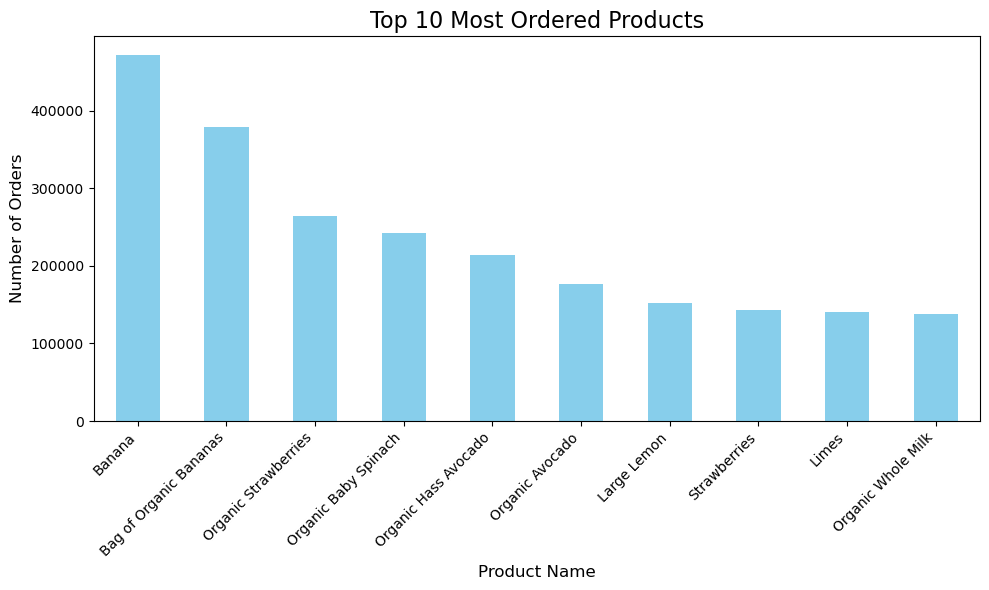

In [40]:
plt.figure(figsize=(10, 6))  
Top_10_product.plot(kind='bar', color='skyblue')

plt.title('Top 10 Most Ordered Products', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()  
plt.show()

Comment: 
1. There is a significant gap between the number of orders for Bananas and other products.
2. A majority of the top 10 products are organic, indicating a strong preference for organic items among customers.

##### Bar plot to visualize the most reordered product in the data 

In [101]:
orders_product_merged["reordered"].value_counts()

1.0    19126536
0.0    13307953
Name: reordered, dtype: int64

In [115]:
reorder = orders_product_merged[orders_product_merged["reordered"] == 1]

Top_10_reordered = reorder["product_name"].value_counts().head(10)
Top_10_reordered

Banana                    398609
Bag of Organic Bananas    315913
Organic Strawberries      205845
Organic Baby Spinach      186884
Organic Hass Avocado      170131
Organic Avocado           134044
Organic Whole Milk        114510
Large Lemon               106255
Organic Raspberries       105409
Strawberries               99802
Name: product_name, dtype: int64

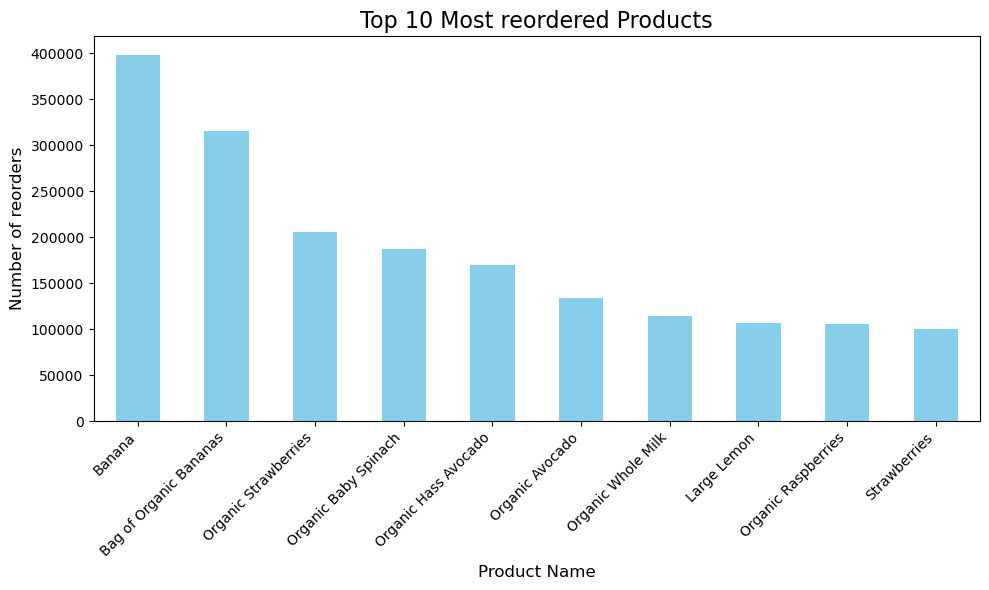

In [49]:
plt.figure(figsize=(10, 6))  
Top_10_reordered.plot(kind='bar', color='skyblue')

plt.title('Top 10 Most reordered Products', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of reorders', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()  
plt.show()

Comment: Very Similar to previous analysis (ordered)
1. Bananas remain the most reordered product, with nearly 400,000 reorders.
2. Organic products again seem to be reordered alot

##### Most Ordered Departments or Aisles: Show the total number of orders by department (e.g., produce, dairy) or aisles to understand which departments are the most popular

In [52]:
departments = department_aisle_merged["department"].value_counts()
Top_10_department = departments.head(10)
Top_10_department

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
Name: department, dtype: int64

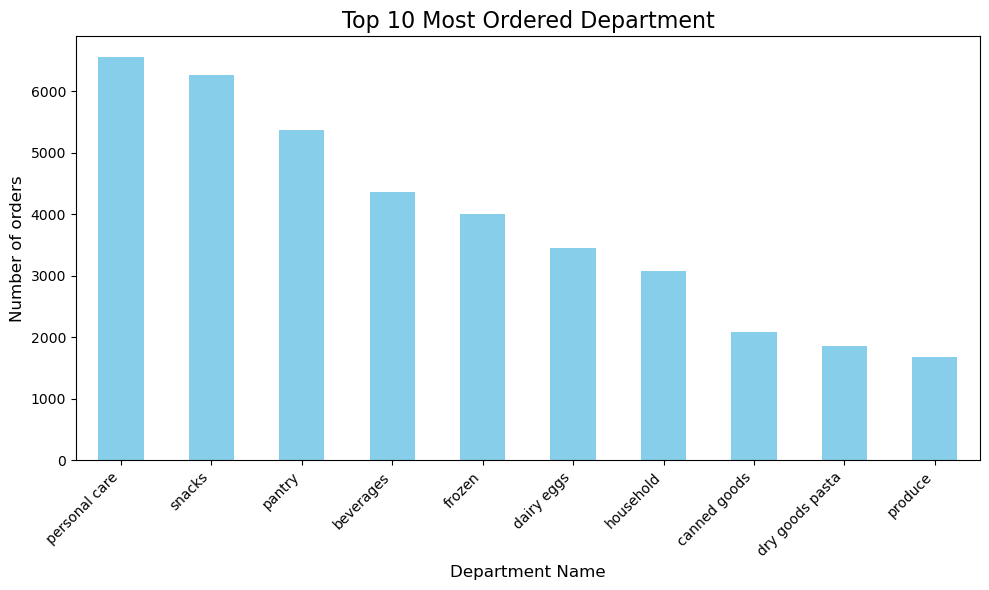

In [53]:
# Bar plot to visualize the most ordered department in the data
plt.figure(figsize=(10, 6))  
Top_10_department.plot(kind='bar', color='skyblue')

plt.title('Top 10 Most Ordered Department', fontsize=16)
plt.xlabel('Department Name', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()  
plt.show()

Comment: 
1. Departments like Snacks, Pantry, and Beverages appear at the top, indicating that customers frequently order items that can be stored for longer periods.
2. Items from departments like Personal Care, Household, and Dairy & Eggs are also commonly ordered, which makes sense as they reflect the necessity in day-to-day life.

##### Encode the day of week column (dow) from numerical to categorical (the day name) and produce a visualization that shows all orders by day of week and sort the visualization in ascending order based on day of week

In [ ]:
orders_product_merged["order_dow"].astype(category)
order_dow

In [68]:
# Dictionary for mapping day indices to day names
 dow_mapping = {
     0: "Sunday",
     1: "Monday",
     2: "Tuesday",
     3: "Wednesday",
     4: "Thursday",
     5: "Friday",
     6: "Saturday"
 }

orders_product_merged["order_dow"] = orders_product_merged["order_dow"].map(dow_mapping)

# Changing dow to category type
orders_product_merged["order_dow"] = orders_product_merged["order_dow"].astype('category')

In [73]:
dow =  orders_product_merged["order_dow"].value_counts().sort_values(ascending=True)
dow

Thursday     3787215
Wednesday    3844117
Friday       4209533
Tuesday      4217798
Saturday     4500304
Monday       5665856
Sunday       6209666
Name: order_dow, dtype: int64

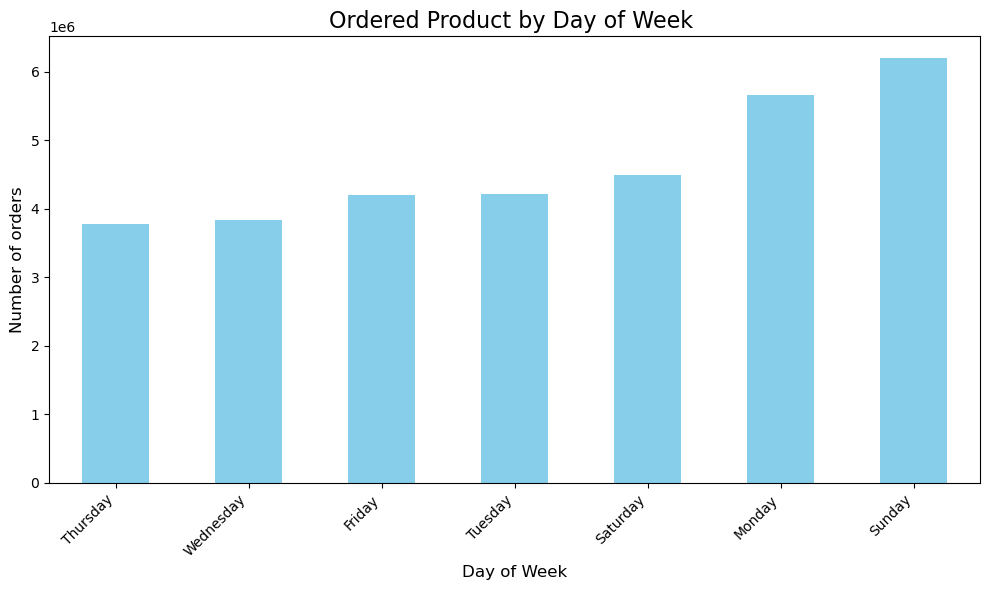

In [74]:
# Bar plot to visualize the most ordered department in the data
plt.figure(figsize=(10, 6))  
dow.plot(kind='bar', color='skyblue')

plt.title('Ordered Product by Day of Week ', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()  
plt.show()

Comment:
1. The number of orders increases significantly on Sunday and Monday, suggesting that customers may prefer to do their shopping towards the end of the weekend or at the beginning of the week.
2. noticeable decrease in order volume on Wednesday and Thursday, which might indicate business as people tend to work within those days

##### What hour of the day are customers most likely to order a product?

In [76]:
Top_5_hrs = orders_product_merged["order_hour_of_day"].value_counts()
Top_5_hrs.head()

10    2764426
11    2738582
14    2691548
15    2664533
13    2663292
Name: order_hour_of_day, dtype: int64

##### A word cloud of products to show the most ordered product 

In [82]:
product_dict = Top_10_product.to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(product_dict)

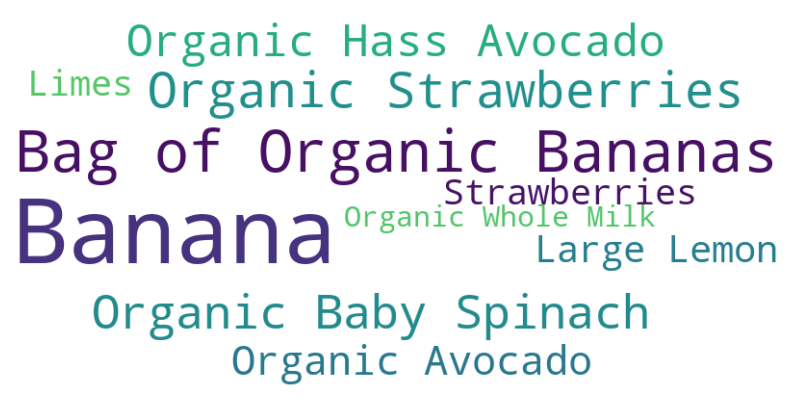

In [83]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

Comment: 
1. The dominance of Banana in size confirms that this product is ordered far more frequently than others and confirms previous visualizations.
2. The word cloud largely consists of fresh produce indicating a preference for healthy products.

##### Hourly/Weekly Order Patterns: Create a heatmap showing the frequency of orders at different times of the day and days of the week. This can reveal peak shopping hours and days.


In [90]:
heatmap_data = orders_product_merged.pivot_table(index='order_dow', 
                                                 columns='order_hour_of_day', 
                                                 values='order_id', 
                                                 aggfunc='count')

In [89]:
orders_product_merged.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id'],
      dtype='object')

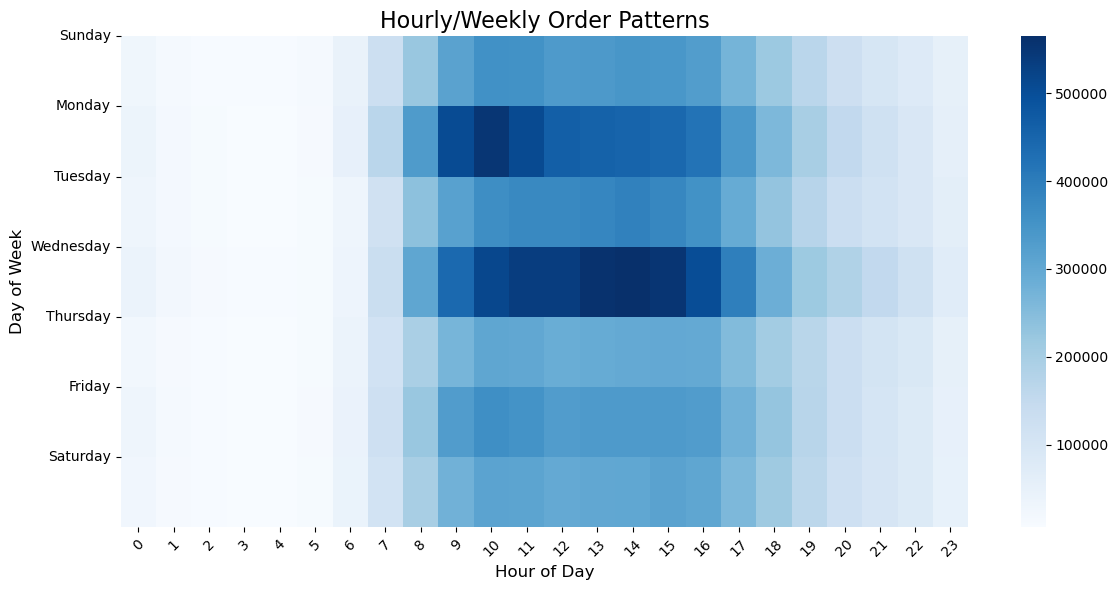

In [91]:
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, cbar=True)

plt.title("Hourly/Weekly Order Patterns", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)

plt.xticks(rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], rotation=0)

plt.tight_layout()
plt.show()

Comment: 
1.  Across most days, the majority of orders are placed between 9 AM and 12 PM, making the morning hours the busiest for online orders.
2. Tuesday to Friday exhibit consistent order patterns, although the volume is slightly lower compared to the peak on Monday and Sunday.

##### Reorder Probability Heatmap: Visualize the likelihood of products being reordered by plotting the reorder probability for different products or departments.

In [118]:
reorder_prob_by_product = orders_product_merged.groupby('product_name')['reordered'].mean().reset_index()

# Sort products by reorder probability
reorder_prob_by_product = reorder_prob_by_product.sort_values(by='reordered', ascending=False).head(10)  # Take top 10 products for visualization

# Create a pivot table for heatmap (if we want to categorize by products)
heatmap_data = reorder_prob_by_product.pivot_table(index='product_name', 
                                                   values='reordered')

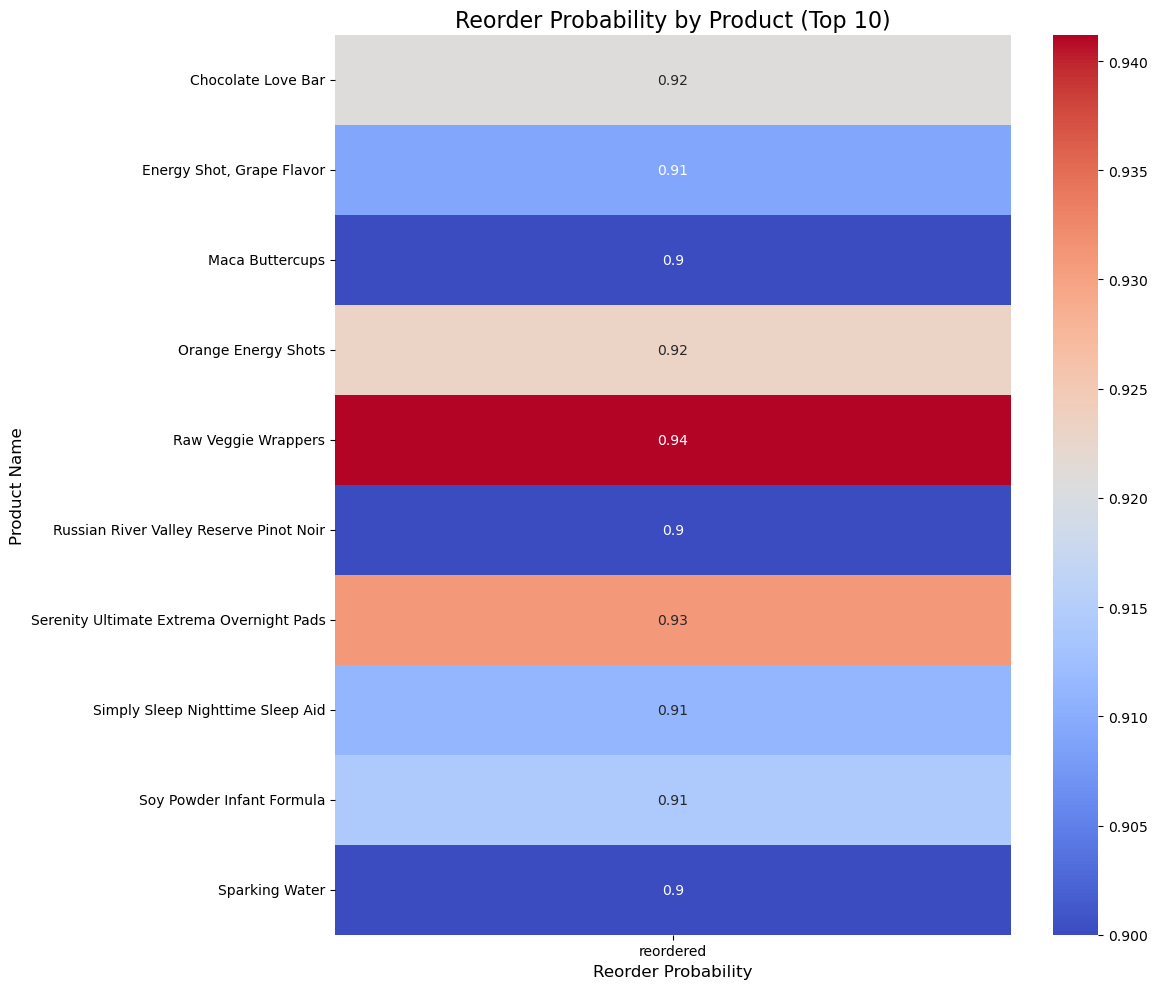

In [119]:
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True)

plt.title("Reorder Probability by Product (Top 10)", fontsize=16)
plt.xlabel("Reorder Probability", fontsize=12)
plt.ylabel("Product Name", fontsize=12)

plt.tight_layout()
plt.show()

Comment: 
1. Reorder probability remains high, ranging from 0.90 to 0.94, indicating that these products are highly likely to be reordered once purchased.

In [97]:
reorder_prob_by_product.head(25)

,product_name,reordered
37375,Raw Veggie Wrappers,0.941176
39866,Serenity Ultimate Extrema Overnight Pads,0.931034
28412,Orange Energy Shots,0.923077
8535,Chocolate Love Bar,0.920792
41719,Soy Powder Infant Formula,0.914286
40454,Simply Sleep Nighttime Sleep Aid,0.911111
13842,"Energy Shot, Grape Flavor",0.909091
38789,Russian River Valley Reserve Pinot Noir,0.900000
24024,Maca Buttercups,0.900000
41798,Sparking Water,0.900000


##### Proportion of Reordered vs. New Products: Stack orders by whether they are reorders or first-time purchases to observe reorder trends across departments or products.

In [102]:
reorder_counts_by_product = orders_product_merged.groupby(['product_name', 'reordered']).size().unstack(fill_value=0)

# Normalize to get proportions (convert counts to proportions)
reorder_proportions_by_product = reorder_counts_by_product.div(reorder_counts_by_product.sum(axis=1), axis=0)

top_products = reorder_proportions_by_product.sum(axis=1).sort_values(ascending=False).head(10)
reorder_proportions_by_top_products = reorder_proportions_by_product.loc[top_products.index]

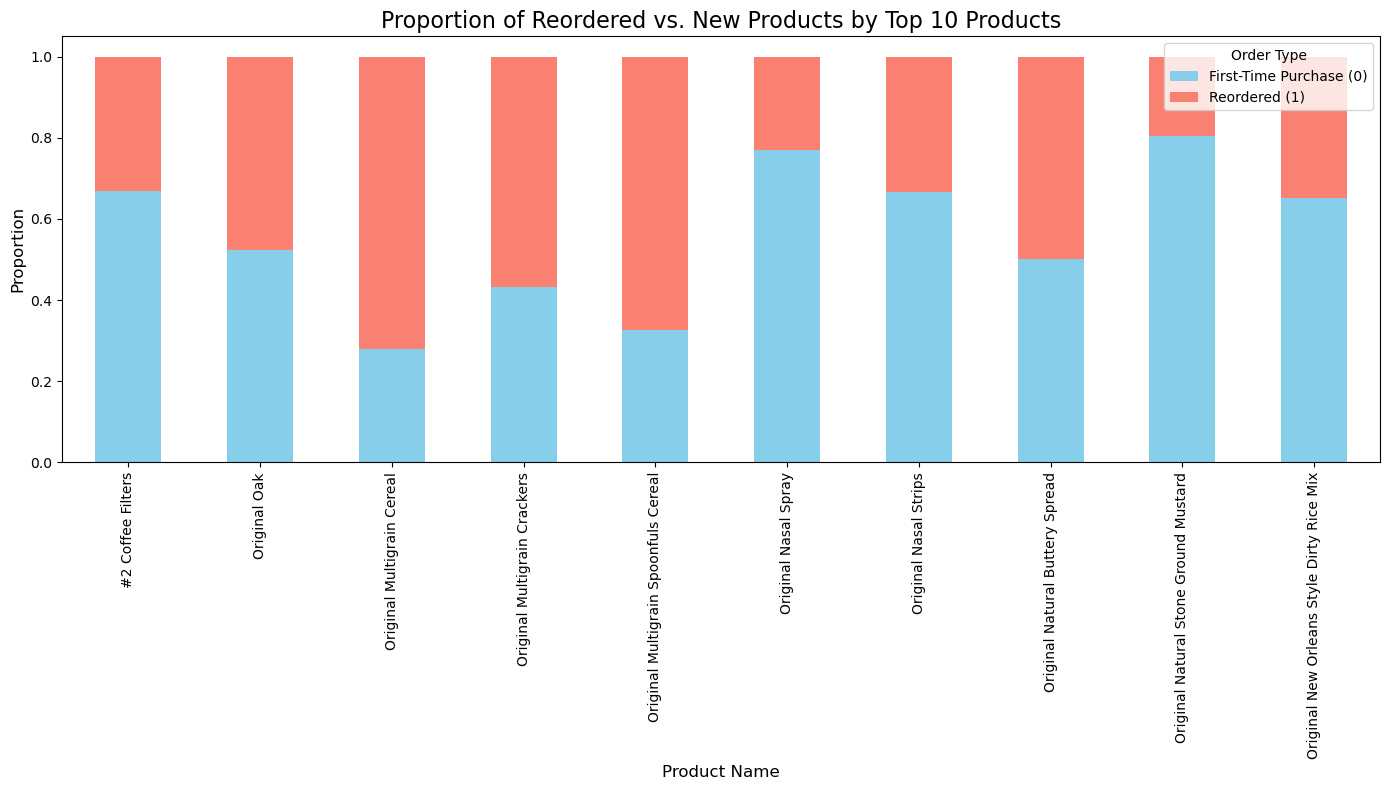

In [103]:
# stacked bar chart for top 20 products
reorder_proportions_by_top_products.plot(kind='bar', stacked=True, figsize=(14, 8), color=['skyblue', 'salmon'])

plt.title('Proportion of Reordered vs. New Products by Top 10 Products', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

plt.legend(['First-Time Purchase (0)', 'Reordered (1)'], title='Order Type', fontsize=10)

plt.tight_layout()
plt.show()

Comment: 
1. Products that are consumables, such as Coffee Filters and Cereals, tend to have higher reorder rates, likely due to their frequent use and need for replenishment.
2. Products, such as the Buttery Spread and Rice Mix, have more even proportions of first-time and reordered purchases, indicating that these are items customers try but may not reorder as frequently.

##### Customer Behavior by Order Size: A histogram or density plot showing the distribution of order sizes (number of items per order). You can segment by customers to identify groups with smaller or larger basket sizes.

In [120]:
order_sizes = orders_product_merged.groupby('order_id').size()

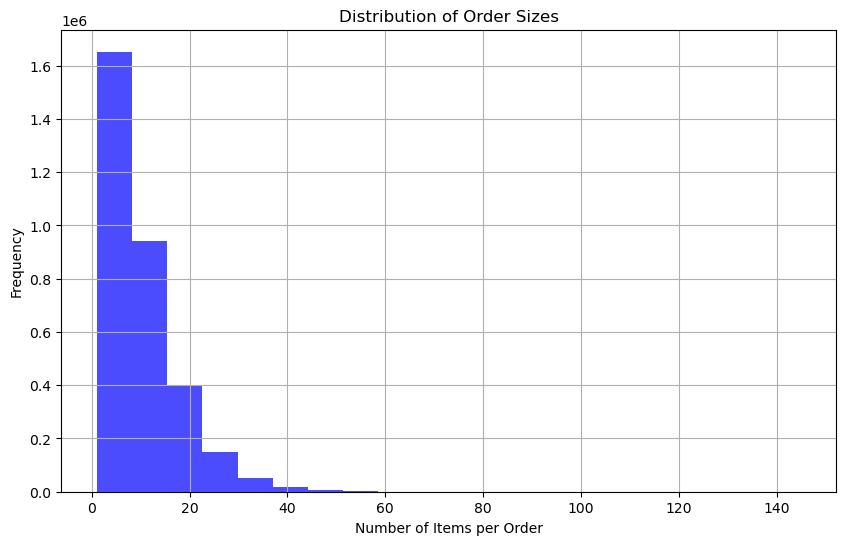

In [121]:
customer_order_sizes = orders_product_merged.groupby(['user_id', 'order_id']).size().reset_index(name='order_size')


plt.figure(figsize=(10, 6))
plt.hist(order_sizes, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Order Sizes')
plt.xlabel('Number of Items per Order')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Comment:
1. The distribution is heavily skewed to the left, indicating that most customers tend to place smaller orders
2. Majority of orders are fewer than 20. Small to medium sized orders tend to dominate

##### Loyalty Analysis: Bar plots showing the percentage of reorders by customers to understand customer loyalty.

In [109]:
# mean of the 'reordered' column
customer_reorder_percentage = orders_product_merged.groupby('user_id')['reordered'].mean().reset_index()

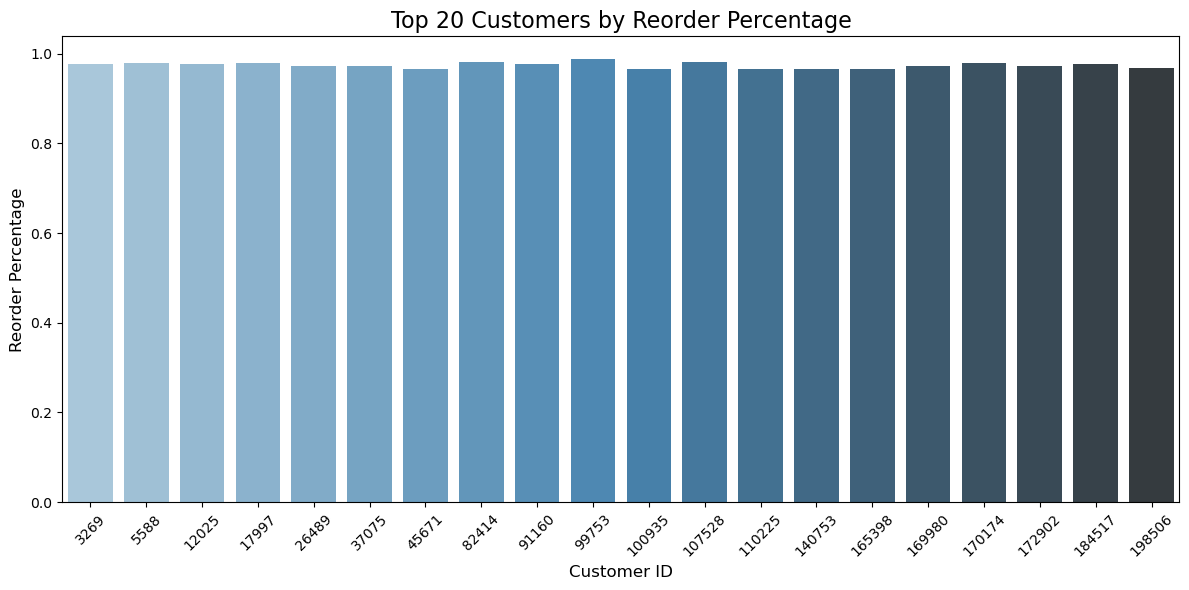

In [111]:
top_customers = customer_reorder_percentage.sort_values(by='reorder_percentage', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='reorder_percentage', data=top_customers, palette='Blues_d')

plt.title('Top 20 Customers by Reorder Percentage', fontsize=16)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Reorder Percentage', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Comment:
1. Strong loyalty to certain products, once they find a product they like, they tend to stick to it.
2. These customers could be targetted through marketting strategies as they are inclined to repeat purchases.